# BNP Paribas Cardif Claims Management


## Problem Description

As a global specialist in personal insurance, BNP Paribas Cardif serves 90 million clients in 36 countries across Europe, Asia and Latin America.

In a world shaped by the emergence of new uses and lifestyles, everything is going faster and faster. When facing unexpected events, customers expect their insurer to support them as soon as possible. However, claims management may require different levels of check before a claim can be approved and a payment can be made. With the new practices and behaviors generated by the digital economy, this process needs adaptation thanks to data science to meet the new needs and expectations of customers.



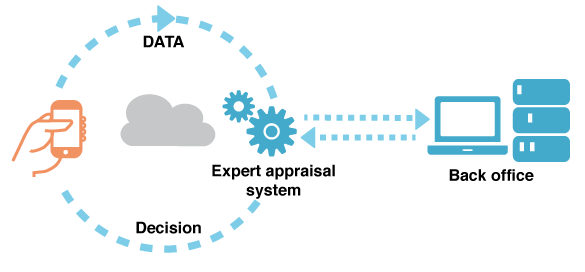

In [23]:
from IPython.display import Image
Image("images/Kaggle_pic_1.PNG")

## Objective

In this challenge, BNP Paribas Cardif is providing an anonymized database with two categories of claims: 1 and 2

Kagglers are challenged to predict the category of a claim based on features available early in the process, helping BNP Paribas Cardif accelerate its claims process and therefore provide a better service to its customers.

You are provided with an anonymized dataset containing both categorical and numeric variables available when the claims were received by BNP Paribas Cardif. All string type variables are categorical. There are no ordinal variables.

The "target" column in the train set is the variable to predict. It is equal to 1 for claims suitable for an accelerated approval.

The task is to predict a probability ("PredictedProb") for each claim in the test set.

## Approach

This notebook contains an implementation in Python of one of the top solutions available at Kaggle(see Reference) with slight modification, e.g. the model applied, which also wasn't optimized for this particular problem.

## Reference

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/overview
https://www.kaggle.com/stephanjo/xgboost-with-combination-of-factors

In [ ]:
# import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistic lib
from scipy import stats
from scipy.stats import skew, norm

# Sklearn lib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder,QuantileTransformer
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import classification_report, confusion_matrix 
#from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

# Models
import lightgbm as lgb
from lightgbm importLGBMClassifier

# Utils
#import math, string, os
#import datetime
#from IPython.display import Image
#from functools import partial
import tqdm
from tqdm import tqdm_notebook
from itertools import combinations,combinations_with_replacement


# Options
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_seq_items = 300
pd.options.display.max_rows = 300
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


import gc
gc.enable()

In [2]:
train = pd.read_csv('dataset_treino.csv')
test = pd.read_csv('dataset_teste.csv')
id_test = test.ID

In [3]:

def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Great! There are no missing values in this dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)
    

def scale_and_normalize(X, scaler_x, norm_x, exception_list= None, y= None, scaler_y= None, transform_y = False, train_or_test = 'train'):
    '''
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    rscaler_x = RobustScaler()
    rscaler_y = RobustScaler()

    jtrans_x = PowerTransformer(method='yeo-johnson')
    jtrans_y = PowerTransformer(method='yeo-johnson')

    boxcox_x = PowerTransformer(method='box-cox')
    boxcox_y = PowerTransformer(method='box-cox')

    qt_x = QuantileTransformer(output_distribution='normal')
    qt_y = QuantileTransformer(output_distribution='normal')
    '''
    
    temp_X = X.copy()
    scaled_y = pd.DataFrame()
    
    
    # Select features that will be transformed
    select = [c for c in temp_X.columns if c not in exception_list]
    temp_X_partial = temp_X[select]
    
    if train_or_test == 'train':
        # Fit and Transform in X - Train
        df_normalized = pd.DataFrame(norm_x.fit_transform(temp_X_partial))
        df_scaled = pd.DataFrame(scaler_x.fit_transform(df_normalized))
        df_scaled.columns = select
        temp_X[select] = df_scaled
        print('Fit and transform X - train done')
    
        if (y is not None) and (transform_y == True):
            scaled_y = y.copy()
            # Fit and Transform in Y - Train
            scaled_y = pd.DataFrame(scaler_y.fit_transform(np.array(y).reshape(-1, 1)))
            print('Fit and transform y - train done')
    
    if (train_or_test == 'test') or (train_or_test == 'val') :
        # Transform X - Test
        df_normalized = pd.DataFrame(norm_x.transform(temp_X_partial))
        df_scaled = pd.DataFrame(scaler_x.transform(df_normalized))
        df_scaled.columns = select
        temp_X[select] = df_scaled
        print('Transform X - test done')
    
        if (y is not None) and (transform_y == True):
            scaled_y = y.copy()
            # Transform Y - Test
            scaled_y = pd.DataFrame(scaler_y.transform(np.array(y).reshape(-1, 1)))
            print('Transform y - test done')
    
    return temp_X, scaled_y, scaler_x, scaler_y, norm_x


    
def create_interactions(df):
    df_categorical = df.select_dtypes('object')
    df  = df_categorical.copy()
    interaction_list = list(combinations(df_categorical, 2))    
    
    
    for i,j in interaction_list:
        #print(i+'_'+j)

        df[i+j] = df[i].astype(str) +' '+ df[j].astype(str)

    return df

def create_interactions_v22(df):
    df_categorical = df.select_dtypes('object')
    df_v22 = df_categorical.copy()
    df_categorical = df_categorical.iloc[:,25:]
    
    df  = pd.DataFrame()  
    
    for col in df_categorical.columns:
        #print('v22_'+col)
        col_name = 'v22'+ col
        df[col_name] = df_v22['v22'].astype(str) +' '+ df_categorical[col].astype(str)

    return df

def create_interactions_all(df):
    df_categorical = df.select_dtypes('object')
    df_all  = df_categorical.copy()
    interaction_list = list(combinations(df_categorical, 11))
    df  = pd.DataFrame()
    for i in interaction_list:
        #print(i)
        #print(i[0]+'_'+i[1]+'_'+i[2]+'_'+i[3]+'_'+i[4]+'_'+i[5]+'_'+i[6]+'_'+i[7]+'_'+i[8]+'_'+i[9]+'_'+i[10])
        df[i[0]+i[1]+i[2]+i[3]+i[4]+i[5]+i[6]+i[7]+i[8]+i[9]+i[10]] = df_categorical[i[0]].astype(str) +' '+ df_categorical[i[1]].astype(str) + ' ' +df_categorical[i[2]].astype(str) +' '+ df_categorical[i[3]].astype(str) + ' '+df_categorical[i[4]].astype(str) +' '+ df_categorical[i[5]].astype(str) + ' '+df_categorical[i[6]].astype(str) +' '+ df_categorical[i[7]].astype(str) + ' '+df_categorical[i[8]].astype(str) +' '+ df_categorical[i[9]].astype(str) + ' '+df_categorical[i[10]].astype(str)                

    return df

def fillna(train, test,n):
    for col in train.columns:
        if col not in ['target']:
            if col in ['v10', 'v12', 'v14', 'v21', 'v34', 'v38', 'v40', 'v50', 'v62',
       'v72', 'v114', 'v129', 'v40v50']:
                test[col].replace(np.nan,train[col].median(), inplace= True)
                train[col].replace(np.nan,train[col].median(), inplace= True)
            else:
                test[col].replace(np.nan,n, inplace= True)
                train[col].replace(np.nan,n, inplace= True)
aggs = {}

aggs['target'] = ['mean']

In [4]:
feat = ['target','v10','v12','v14','v21','v22','v24','v30','v31','v34','v38','v40','v47','v50','v52','v56','v62','v66','v72','v75','v79','v91','v112','v113','v114','v129']
features_train = [x for x in train.columns if x in feat]
features_test = [x for x in test.columns if x in feat]
train = train[features_train]
test = test[features_test]
train['v40v50'] = train['v40']-train['v50']
test['v40v50'] = test['v40']-test['v50']
fillna(train,test,'NA')

In [5]:
df_categorical_train = train.select_dtypes('object')
df_numerical_train = train.select_dtypes('number')
print('Train shape: ', train.shape)
print('Categorical features: ', df_categorical_train.shape[1],'/',train.shape[1])
print('Numerical features:   ', df_numerical_train.shape[1],'/',train.shape[1])

df_categorical_test = test.select_dtypes('object')
df_numerical_test = test.select_dtypes('number')
print('\nTest shape:  ', test.shape)
print('Categorical features: ', df_categorical_test.shape[1],'/',test.shape[1])
print('Numerical features:   ', df_numerical_test.shape[1],'/',test.shape[1])

Train shape:  (114321, 27)
Categorical features:  13 / 27
Numerical features:    14 / 27

Test shape:   (114393, 26)
Categorical features:  13 / 26
Numerical features:    13 / 26


In [6]:
%%time
train_temp1 = create_interactions(train)
train_temp2 = create_interactions_v22(train_temp1)
train_temp3 = create_interactions_all(train)

test_temp1 = create_interactions(test)
test_temp2 = create_interactions_v22(test_temp1)
test_temp3 = create_interactions_all(test)

CPU times: user 39.7 s, sys: 3.22 s, total: 42.9 s
Wall time: 42.9 s


In [7]:
print('Train dataset: ')
print('Created 2-level categorical interactions:  ', train_temp1.shape[1] - df_categorical_train.shape[1]) # x[i] vs x[i+1] , temp1 also contains each categorical variable
print('Created 3-level categorical interactions:  ', train_temp2.shape[1]) # v[22] vs x[i] vs x[i+1]
print('Created 11-level categorical interactions: ', train_temp3.shape[1]) # x[i] vs x[i+1] vs x[...] vs x[n]

print('\nTest dataset: ')
print('Created 2-level categorical interactions:  ', test_temp1.shape[1] - df_categorical_test.shape[1]) # x[i] vs x[i+1] , temp1 also contains each categorical variable
print('Created 3-level categorical interactions:  ', test_temp2.shape[1]) # v[22] vs x[i] vs x[i+1]
print('Created 11-level categorical interactions: ', test_temp3.shape[1]) # x[i] vs x[i+1] vs x[...] vs x[n]

Train dataset: 
Created 2-level categorical interactions:   78
Created 3-level categorical interactions:   66
Created 11-level categorical interactions:  78

Test dataset: 
Created 2-level categorical interactions:   78
Created 3-level categorical interactions:   66
Created 11-level categorical interactions:  78


### Save initial interactions

In [ ]:
train_temp1.to_pickle('train_temp1_in.pkl')
train_temp2.to_pickle('train_temp2_in.pkl')
train_temp3.to_pickle('train_temp3_in.pkl')

test_temp1.to_pickle('test_temp1_in.pkl')
test_temp2.to_pickle('test_temp2_in.pkl')
test_temp3.to_pickle('test_temp3_in.pkl')

In [ ]:
train_temp1 = pd.read_pickle('train_temp1_in.pkl')
train_temp2 = pd.read_pickle('train_temp2_in.pkl')
train_temp3 = pd.read_pickle('train_temp3_in.pkl')

test_temp1 = pd.read_pickle('test_temp1_in.pkl')
test_temp2 = pd.read_pickle('test_temp2_in.pkl')
test_temp3 = pd.read_pickle('test_temp3_in.pkl')

In [ ]:
%%time
le = LabelEncoder()


for col in tqdm.tqdm(train_temp1.columns):
    le.fit(np.unique(list(train_temp1[col].values) + list(test_temp1[col].values)))
    train_temp1[col] = le.transform(train_temp1[col])
    test_temp1[col] = le.transform(test_temp1[col])

for col in tqdm.tqdm(train_temp2.columns):
    le.fit(np.unique(list(train_temp2[col].values) + list(test_temp2[col].values)))
    train_temp2[col] = le.transform(train_temp2[col])
    test_temp2[col] = le.transform(test_temp2[col])
    
for col in tqdm.tqdm(train_temp3.columns):
    le.fit(np.unique(list(train_temp3[col].values) + list(test_temp3[col].values)))
    train_temp3[col] = le.transform(train_temp3[col])
    test_temp3[col] = le.transform(test_temp3[col])

In [ ]:
train_temp3['target'] = train['target']
train_temp2['target'] = train['target']
train_temp1['target'] = train['target']

train_temp1_fx = train_temp1.copy()
train_temp2_fx = train_temp2.copy()
train_temp3_fx = train_temp3.copy()

test_temp1_fx = test_temp1.copy()
test_temp2_fx = test_temp2.copy()
test_temp3_fx = test_temp3.copy()

In [ ]:
%%time
aggs = {}

aggs['target'] = ['mean']

exception = ['target']
loop_train_temp1 = [col for col in train_temp1.columns if col not in exception]
loop_train_temp2 = [col for col in train_temp2.columns if col not in exception]
loop_train_temp3 = [col for col in train_temp3.columns if col not in exception]

loop_train_temp1_len = len(loop_train_temp1)
loop_train_temp2_len = len(loop_train_temp2)
loop_train_temp3_len = len(loop_train_temp3)

for i, col in tqdm.tqdm(enumerate(loop_train_temp1)):
    
    print('Col: {}, {}/{}'.format(col, i+1, loop_train_temp1_len))
    mean_data = (train_temp1_fx.groupby([col]).agg(aggs)).T
    mean_dict = mean_data.to_dict('records')
    new_col = str(col)+'_'
    train_temp1[new_col] = np.nan
    test_temp1[new_col] = np.nan
    
    all_lst = np.arange(0,len(train_temp1_fx))
    
    for i in tqdm.tqdm(range(4)):
        partial_lst = np.arange(i,len(train_temp1_fx),4)
        to_fill_lst = np.delete(all_lst, partial_lst)

        partial_mean = (train_temp1_fx.ix[to_fill_lst].groupby([col]).agg(aggs)).T
        col_dict = partial_mean.to_dict('records')
        
        train_temp1.ix[partial_lst,[new_col]] = (train_temp1.ix[partial_lst][col]).map(col_dict[0])

    
    test_temp1.ix[:,[new_col]] = (test_temp1_fx.ix[:][col]).map(mean_dict[0])
    del train_temp1[col]
    del test_temp1[col]
    
del train_temp1['target']


for i, col in tqdm.tqdm(enumerate(loop_train_temp2)):
    
    print('Col: {}, {}/{}'.format(col, i+1, loop_train_temp2_len))
    mean_data = (train_temp2_fx.groupby([col]).agg(aggs)).T
    mean_dict = mean_data.to_dict('records')
    new_col = str(col)+'_'
    train_temp2[new_col] = np.nan
    test_temp2[new_col] = np.nan
    all_lst = np.arange(0,len(train_temp2_fx))

    for i in tqdm.tqdm(range(4)):
        partial_lst = np.arange(i,len(train_temp2_fx),4)
        to_fill_lst = np.delete(all_lst, partial_lst)

        partial_mean = (train_temp2_fx.ix[to_fill_lst].groupby([col]).agg(aggs)).T
        col_dict = partial_mean.to_dict('records')
        
        train_temp2.ix[partial_lst,[new_col]] = (train_temp2.ix[partial_lst][col]).map(col_dict[0])        

        

    test_temp2.ix[:,[new_col]] = (test_temp2_fx.ix[:][col]).map(mean_dict[0])
    del train_temp2[col]
    del test_temp2[col]
    
del train_temp2['target']
    
for i, col in tqdm.tqdm(enumerate(loop_train_temp3)):
    
    print('Col: {}, {}/{}'.format(col, i+1, loop_train_temp3_len))
    mean_data = (train_temp3_fx.groupby([col]).agg(aggs)).T
    mean_dict = mean_data.to_dict('records')
    new_col = str(col)+'_'
    train_temp3[new_col] = np.nan
    test_temp3[new_col] = np.nan
    all_lst = np.arange(0,len(train_temp3_fx))
    
    for i in tqdm.tqdm(range(4)):
        partial_lst = np.arange(i,len(train_temp3_fx),4)
        to_fill_lst = np.delete(all_lst, partial_lst)

        partial_mean = (train_temp3_fx.ix[to_fill_lst].groupby([col]).agg(aggs)).T
        col_dict = partial_mean.to_dict('records')
        
        train_temp3.ix[partial_lst,[new_col]] = (train_temp3.ix[partial_lst][col]).map(col_dict[0])      

    test_temp3.ix[:,[new_col]] = (test_temp3_fx.ix[:][col]).map(mean_dict[0])
    del train_temp3[col]
    del test_temp3[col]
    
del train_temp3['target']

In [ ]:
train_temp1.to_pickle('train_temp1_final.pkl')
train_temp2.to_pickle('train_temp2_final.pkl')
train_temp3.to_pickle('train_temp3_final.pkl')

test_temp1.to_pickle('test_temp1_final.pkl')
test_temp2.to_pickle('test_temp2_final.pkl')
test_temp3.to_pickle('test_temp3_final.pkl')

In [ ]:
train_temp1 = pd.read_pickle('train_temp1_final.pkl')
train_temp2 = pd.read_pickle('train_temp2_final.pkl')
train_temp3 = pd.read_pickle('train_temp3_final.pkl')

test_temp1 = pd.read_pickle('test_temp1_final.pkl')
test_temp2 = pd.read_pickle('test_temp2_final.pkl')
test_temp3 = pd.read_pickle('test_temp3_final.pkl')

In [ ]:
train_temp1_in = pd.read_pickle('train_temp1_in.pkl')
train_temp2_in = pd.read_pickle('train_temp2_in.pkl')
train_temp3_in = pd.read_pickle('train_temp3_in.pkl')

test_temp1_in = pd.read_pickle('test_temp1_in.pkl')
test_temp2_in = pd.read_pickle('test_temp2_in.pkl')
test_temp3_in = pd.read_pickle('test_temp3_in.pkl')

In [ ]:
rename_temp1 = [col.split('_')[0] for col in train_temp1.columns]
rename_temp2 = [col.split('_')[0] for col in train_temp2.columns]
rename_temp3 = [col.split('_')[0] for col in train_temp3.columns]
for df in [train_temp1, test_temp1]:
    df.columns = rename_temp1
for df in [train_temp2, test_temp2]:
    df.columns = rename_temp2
for df in [train_temp3, test_temp3]:
    df.columns = rename_temp3

In [ ]:
%%time
exception = ['target']
loop_train_temp1 = [col for col in train_temp1.columns if col not in exception]
loop_train_temp2 = [col for col in train_temp2.columns if col not in exception]
loop_train_temp3 = [col for col in train_temp3.columns if col not in exception]

loop_train_temp1_len = len(loop_train_temp1)
loop_train_temp2_len = len(loop_train_temp2)
loop_train_temp3_len = len(loop_train_temp3)

for i, col in tqdm.tqdm(enumerate(loop_train_temp1)):
    
    #print('Col: {}, {}/{}'.format(col, i, loop_train_temp1_len))
    lst = train_temp1_in.ix[train_temp1_in[col].str.contains('NA')==True,col].index
    train_temp1.loc[lst,[col]] = np.nan
    lst = test_temp1_in.ix[test_temp1_in[col].str.contains('NA')==True,col].index
    test_temp1.loc[lst,[col]] = np.nan

for i, col in tqdm.tqdm(enumerate(loop_train_temp2)):
    
    #print('Col: {}, {}/{}'.format(col, i, loop_train_temp2_len))
    lst = train_temp2_in.ix[train_temp2_in[col].str.contains('NA')==True,col].index
    train_temp2.loc[lst,[col]] = np.nan
    lst = test_temp2_in.ix[test_temp2_in[col].str.contains('NA')==True,col].index
    test_temp2.loc[lst,[col]] = np.nan
    
for i, col in tqdm.tqdm(enumerate(loop_train_temp3)):
    
    #print('Col: {}, {}/{}'.format(col, i, loop_train_temp3_len))
    lst = train_temp3_in.ix[train_temp3_in[col].str.contains('NA')==True,col].index
    train_temp3.loc[lst,[col]] = np.nan
    lst = test_temp3_in.ix[test_temp3_in[col].str.contains('NA')==True,col].index
    test_temp3.loc[lst,[col]] = np.nan

In [ ]:
train_temp1.to_pickle('train_temp1_2.pkl')
train_temp2.to_pickle('train_temp2_2.pkl')
train_temp3.to_pickle('train_temp3_2.pkl')

test_temp1.to_pickle('test_temp1_2.pkl')
test_temp2.to_pickle('test_temp2_2.pkl')
test_temp3.to_pickle('test_temp3_2.pkl')

In [ ]:
train_temp1 = pd.read_pickle('train_temp1_2.pkl')
train_temp2 = pd.read_pickle('train_temp2_2.pkl')
train_temp3 = pd.read_pickle('train_temp3_2.pkl')

test_temp1 = pd.read_pickle('test_temp1_2.pkl')
test_temp2 = pd.read_pickle('test_temp2_2.pkl')
test_temp3 = pd.read_pickle('test_temp3_2.pkl')

In [ ]:
train_expanded = pd.concat([df_numerical_train, train_temp1,train_temp2,train_temp3],   axis=1)
test_expanded  = pd.concat([df_numerical_test, test_temp1,test_temp2,test_temp3], axis=1)


print('Train: ', train_expanded.shape); print('Test:  ', test_expanded.shape)

In [ ]:
to_drop = ['v22']
train_expanded.drop(to_drop, axis=1, inplace=True)
test_expanded.drop(to_drop, axis=1, inplace=True)

In [ ]:
train_expanded.to_pickle('train_expanded.pkl')
test_expanded.to_pickle('test_expanded.pkl')

In [8]:
train_expanded = pd.read_pickle('train_expanded.pkl')
test_expanded = pd.read_pickle('test_expanded.pkl')

In [10]:
fillna(train_expanded,test_expanded, 0.8)

In [11]:
check_missing(train_expanded)
check_missing(test_expanded)

Great! There are no missing values in this dataset.
Great! There are no missing values in this dataset.


In [12]:
features = [col for col in train_expanded.columns if col not in ['target', 'ID']]
X = train_expanded[features]
y = train_expanded['target']
print(X.shape)
X_test = test_expanded[features]

(114321, 247)


In [13]:
gc.collect()

40

In [14]:
%%time
from sklearn.preprocessing import QuantileTransformer


exception_lst = ['target','ID']


qt = QuantileTransformer(output_distribution='normal')
scaler_x = StandardScaler()
'''
X_scaled, _, scaler_x, _ = scale_and_normalize(X, scaler_x= scaler_x, exception_list= exception_lst, 
                                               y= y, scaler_y= None, transform_y = False, train_or_test = 'train')

X_test_scaled, _, _, _ = scale_and_normalize(X_test, scaler_x= scaler_x, exception_list= exception_lst, 
                                               y= y, scaler_y= None, transform_y = False, train_or_test = 'test')
'''
X_scaled, _ , scaler_x, _, norm_x = scale_and_normalize(X, 
                                              scaler_x= scaler_x, 
                                              norm_x = qt , 
                                              exception_list= exception_lst, 
                                              y= None, 
                                              scaler_y= None, 
                                              transform_y = False, 
                                              train_or_test = 'train')

X_test_scaled, _ , _, _, _ = scale_and_normalize(X_test, 
                                              scaler_x= scaler_x, 
                                              norm_x = norm_x , 
                                              exception_list= exception_lst, 
                                              y= None, 
                                              scaler_y= None, 
                                              transform_y = False, 
                                              train_or_test = 'test')


Fit and transform X - train done
Transform X - test done
CPU times: user 44.1 s, sys: 2.23 s, total: 46.3 s
Wall time: 8.48 s


In [15]:
%%time
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedKFold
import time

X_train = X_scaled
y_train = y
X_test = X_test_scaled

param = {
    'boosting_type':'gbdt',
    'learning_rate' : 0.1, 
    'n_estimators' : 1000, 
    'max_depth' : -1,
    'min_child_samples':231,
    'min_child_weight' : 0.1,
    'gamma' : 0.04, 
    'subsample' : 0.5,
    'colsample_bytree' : 0.991,
    'reg_alpha' : 1,
    'num_leaves':11,
    'reg_lambda':10,
    'objective' : 'binary', 
    'n_jobs' : 4,
    'scale_pos_weight' : 1, 
    'seed' : 42
}


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(kfold.split(X_train,y_train)):


    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx],
                           label=y_train.iloc[trn_idx]
                          )
    val_data = lgb.Dataset(X_train.iloc[val_idx],
                           label=y_train.iloc[val_idx]
                          )

    num_round = 100
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1 
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / kfold.n_splits

print("CV score: {:<8.5f}".format(log_loss(y_train, oof)))



fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.43823	valid_1's binary_logloss: 0.448676
[200]	training's binary_logloss: 0.427819	valid_1's binary_logloss: 0.445805
[300]	training's binary_logloss: 0.419894	valid_1's binary_logloss: 0.445134
[400]	training's binary_logloss: 0.412744	valid_1's binary_logloss: 0.444711
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.413304	valid_1's binary_logloss: 0.444649
fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.439392	valid_1's binary_logloss: 0.444628
[200]	training's binary_logloss: 0.42901	valid_1's binary_logloss: 0.442096
[300]	training's binary_logloss: 0.420689	valid_1's binary_logloss: 0.441177
[400]	training's binary_logloss: 0.413316	valid_1's binary_logloss: 0.440864
[500]	training's binary_logloss: 0.406521	valid_1's binary_logloss: 0.440746
Early stopping, best iteration is:
[424]	training's binary_

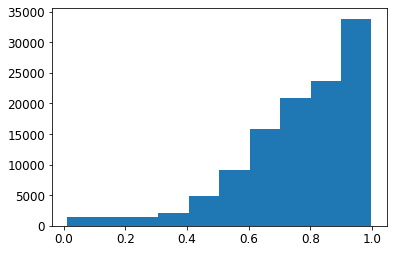

In [16]:
# Calculates the correlation and plot the data in s heatmap
plt.hist(predictions)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [17]:
pd.DataFrame(predictions).describe()

,0
count,114393.00000
mean,0.76238
std,0.19480
min,0.01073
25%,0.66076
50%,0.80195
75%,0.91827
max,0.99838


In [18]:
submission = pd.DataFrame({"ID": id_test, "PredictedProb": predictions})
submission.to_csv("submission.csv", index=False)